In [67]:
import numpy as np
import math

import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
from matplotlib import ticker
import matplotlib.gridspec as gridspec

from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

from IPython.display import Image
from datetime import date

from tqdm import tqdm
import os 

In [68]:
Years = ["2000","2001","2002","2003","2004","2005","2006","2007","2008","2009"]
N_year = len(Years)

Months = []
for imon in range(1,13): ### shw
    Months.append(str(imon).zfill(2))
    
Days = []
for iday in range(1,30,3):
    Days.append(str(iday).zfill(2))
    
print(Years)
print(Months)
print(Days)

['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
['01', '04', '07', '10', '13', '16', '19', '22', '25', '28']


In [69]:
Lats_edge = np.arange(-90,91,6)
Lons_edge = np.arange(-180,181,10)

Lats_mid = np.arange(-87,90,6)
Lons_mid = np.arange(-175,180,10)

# Levs    = [100, 75, 65, 55, 40, 30]
# Heights = [16, 18, 19, 20, 22, 24]
Levs    = [100, 75, 65, 55, 47, 40, 30] # hPa
Heights = [16,  17.92, 18.87, 20, 21.05, 22.1, 24] # km
# [100, 75, 55, 40, 30]


N_lat = len(Lats_mid)
N_lon = len(Lons_mid)
N_lev = len(Levs) # 16, 18, 19, 20, 22, 24 km

Lats_edge, Lons_edge, Lats_mid, Lons_mid, N_lat, N_lon, Lons_edge[-1]

(array([-90, -84, -78, -72, -66, -60, -54, -48, -42, -36, -30, -24, -18,
        -12,  -6,   0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,
         66,  72,  78,  84,  90]),
 array([-180, -170, -160, -150, -140, -130, -120, -110, -100,  -90,  -80,
         -70,  -60,  -50,  -40,  -30,  -20,  -10,    0,   10,   20,   30,
          40,   50,   60,   70,   80,   90,  100,  110,  120,  130,  140,
         150,  160,  170,  180]),
 array([-87, -81, -75, -69, -63, -57, -51, -45, -39, -33, -27, -21, -15,
         -9,  -3,   3,   9,  15,  21,  27,  33,  39,  45,  51,  57,  63,
         69,  75,  81,  87]),
 array([-175, -165, -155, -145, -135, -125, -115, -105,  -95,  -85,  -75,
         -65,  -55,  -45,  -35,  -25,  -15,   -5,    5,   15,   25,   35,
          45,   55,   65,   75,   85,   95,  105,  115,  125,  135,  145,
         155,  165,  175]),
 30,
 36,
 180)

In [70]:
# count the particle (injected at different height) number in each grid cell
N_day  = 20*366
Num_2D = np.zeros((N_lat, N_lon, N_lev, N_day)) 


for i_year in tqdm(range(N_year)):
    
    NUMs = np.zeros((N_lon*N_lat*N_day, N_lev))
    
    
    # 6 injection altitudes
    
    # total
    # File1 = open('/n/home12/hongwei/Paper_2/Plot_python/Num_Concnt/Num_Concnt_2000_'+Years[i_year]+'.txt', 'r')
    # File1 = open('/n/home12/hongwei/Paper_3_QBO/Particle_Number_Within_15deg/Num_Concnt_data/Num_Concnt_2000_'+Years[i_year]+'.txt', 'r')
    # File1 = open('/n/home12/hongwei/Paper_3_QBO/Particle_Number_Within_30deg/Num_Concnt_data/Num_Concnt_2000_'+Years[i_year]+'.txt', 'r')

    # lower stratosphere: below 50hPa
    # File1 = open('/n/home12/hongwei/Paper_3_QBO/Particle_Number_Within_15deg/Num_Concnt_data/Num_Concnt_lower_2000_'+Years[i_year]+'.txt', 'r')

    # higher stratosphere: above 50hPa
    File1 = open('/n/home12/hongwei/Paper_3_QBO/Particle_Number_Within_15deg/Num_Concnt_data/Num_Concnt_upper_2000_'+Years[i_year]+'.txt', 'r')
    
    Lines1 = File1.readlines()
    
    ii = 0
    for line1 in Lines1:
        a1 = line1.split(',')
        NUMs[ii,0] = float(a1[3])
        NUMs[ii,1] = float(a1[4])
        NUMs[ii,2] = float(a1[5])
        NUMs[ii,3] = float(a1[6])
        NUMs[ii,5] = float(a1[7])
        NUMs[ii,6] = float(a1[8])
        ii = ii+1

        
    # 21-km injection
    File2 = open('/n/home12/hongwei/Paper_2/Plot_python/21km_post_process/Num_Concnt_21km/Num_Concnt_2000_'+Years[i_year]+'_21km.txt', 'r')
    Lines2 = File2.readlines()
    
    ii = 0
    for line2 in Lines2:
        a2 = line2.split(',')
        NUMs[ii,4] = float(a2[3])
        ii = ii+1        

        
    # remap to global (Lon,Lat) mesh
    Num_2D_temp = np.zeros((N_lat, N_lon, N_lev, N_day)) 
    for i_day in range(N_day):
        for ix in range(N_lon):
            for iy in range(N_lat):
                ii = i_day*(N_lat*N_lon) + ix*N_lat + iy
                Num_2D_temp[iy, ix, :, i_day] = NUMs[ii,:]
               
            
    Num_2D = Num_2D + Num_2D_temp            
    
print(ii)


100%|██████████| 10/10 [06:53<00:00, 41.37s/it]

7905599


In [71]:
# change (-20,20) to (20,-20)

print("LAT Before: ", Lats_mid)

if Lats_mid[0]<Lats_mid[-1]:
    Lats_edge = Lats_edge[::-1]
    Lats_mid = Lats_mid[::-1]
    Num_2D[:, :, :, :] = Num_2D[::-1, :, :, :]

print("LAT After: ", Lats_mid)

LAT Before:  [-87 -81 -75 -69 -63 -57 -51 -45 -39 -33 -27 -21 -15  -9  -3   3   9  15
  21  27  33  39  45  51  57  63  69  75  81  87]
LAT After:  [ 87  81  75  69  63  57  51  45  39  33  27  21  15   9   3  -3  -9 -15
 -21 -27 -33 -39 -45 -51 -57 -63 -69 -75 -81 -87]


(30, 36, 7, 240)


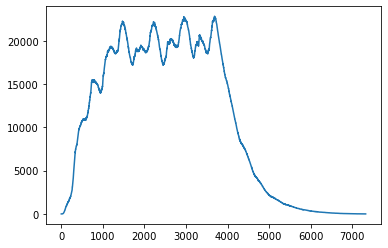

In [72]:
# monthly data
# To simplify, assume all months have 30 days

N_month = 20*12

Num_2D_month = np.zeros((N_lat, N_lon, N_lev, N_month))

for i_mon in range(N_month):
    Num_2D_month[:,:,:,i_mon] = np.mean(Num_2D[:,:,:,i_mon*30:(i_mon+1)*30], axis=3)

print(Num_2D_month.shape)
plt.plot(np.sum(Num_2D[:,:,2,:], axis=(0,1)))

# Be careful about mean() and sum()!!!
## the unit should be [particles] in the steady state

In [73]:
iz = 2
Heights[iz], Levs[iz]

(18.87, 65)

In [74]:
# select 2005.1-2009.12
Num_month_steady = np.mean(Num_2D_month[:,:,iz,5*12:10*12], axis=2)
print(Num_month_steady.shape, np.sum(Num_month_steady))


# select lat index for tropics, mid-lat, and polar regions
iy_polar = list(np.arange(0,5,1))+list(np.arange(25,30,1))
iy_midlat = list(np.arange(5,10,1))+list(np.arange(20,25,1))
iy_tropic = list(np.arange(10,20,1))

print(Lats_mid[iy_polar], Lats_mid[iy_midlat], Lats_mid[iy_tropic])

# get particle number sinking in the three regions
Num_month_tropic = np.sum(Num_month_steady[iy_tropic,:])
Num_month_midlat = np.sum(Num_month_steady[iy_midlat,:])
Num_month_polar = np.sum(Num_month_steady[iy_polar,:])

print(Num_month_tropic, Num_month_midlat, Num_month_polar)
print("total:", Num_month_tropic+Num_month_midlat+Num_month_polar)

(30, 36) 19807.925555555557
[ 87  81  75  69  63 -63 -69 -75 -81 -87] [ 57  51  45  39  33 -33 -39 -45 -51 -57] [ 27  21  15   9   3  -3  -9 -15 -21 -27]
15062.552777777777 4018.7044444444446 726.6683333333333
total: 19807.925555555557


In [75]:
# injection rate changes from 5040 (-30 to 30) to 100 by divided 50.4


Num_month_tropic_scaled = Num_month_tropic/50.4
Num_month_midlat_scaled = Num_month_midlat/50.4
Num_month_polar_scaled = Num_month_polar/50.4

print(Num_month_tropic_scaled, Num_month_midlat_scaled, Num_month_polar_scaled)

298.86017416225747 79.73619929453264 14.418022486772486
